The first part is just defining a function for converting text to numbers,
for example "twenty-one" → 21. You can skip over it as it is not very
relevant to the rest of this notebook.

In [1]:
import re

import lark

numbers_grammar = r"""
number: NUMBER | text_number

?text_number.1: hundred_text_number | dozen_text_number | TEEN_NAME | UNIT_NAME


hundred_text_number.1: (dozen_text_number | UNIT_NAME) "hundred" [ "and" ] [ dozen_text_number | UNIT_NAME ]

dozen_text_number.1: DOZEN_NAME [ UNIT_NAME ] | TEEN_NAME

UNIT_NAME.1: "one"|"two"|"three"|"four"|"five"|"six"|"seven"|"eight"|"nine"

TEEN_NAME.1: "ten"|"eleven"|"twelve"|"thirteen"|"fourteen"|"fifteen"
    |"sixteen"|"seventeen"|"eighteen"|"nineteen"

DOZEN_NAME.1: "twenty"|"thirty"|/fou?rty/|"fifty"|"sixty"|"seventy"|"eighty"
    |"ninety"


WS: /\s+/
PUNCT: /[^a-zA-Z0-9().]/

%import common (NUMBER)
%ignore WS
%ignore PUNCT
"""


class NumberTransformer(lark.Transformer):
    def number(self, tree) -> int:
        return tree[0]

    def hundred_text_number(self, tree) -> int:
        hundred_part, rest = tree
        if rest is None:
            return 100 * hundred_part
        return 100 * hundred_part + rest

    def dozen_text_number(self, tree) -> int:
        if len(tree) == 1:
            teen = tree[0]
            return teen
        dozen, unit = tree
        if unit is None:
            return dozen
        return dozen + unit

    def UNIT_NAME(self, tree) -> int:
        return (
            "zero one two three four five six seven eight nine".split().index(
                tree.value.lower()
            )
        )

    def TEEN_NAME(self, tree) -> int:
        return (
            "ten eleven twelve thirteen fourteen fifteen sixteen "
            "seventeen eighteen nineteen".split().index(tree.value.lower())
            + 10
        )

    def DOZEN_NAME(self, tree) -> int:
        return (
            "zero ten twenty thirty forty fifty sixty "
            "seventy eighty ninety".split().index(
                tree.value.lower().replace("fourty", "forty")
            )
        ) * 10

    def NUMBER(self, tree) -> int:
        return int(tree.value)


class TextToNumber:
    def __init__(self):
        self.parser = lark.Lark(
            numbers_grammar,
            ambiguity="resolve",
            start="number",
            g_regex_flags=re.I,
        )
        self.transformer = NumberTransformer()

    def __call__(self, text):
        try:
            parse_tree = self.parser.parse(text.replace(",", ""))
            return self.transformer.transform(parse_tree)
        except Exception:
            return None


text_to_number = TextToNumber()

# Plot the number of participants

## Load the data
By using pandas to run sql code to query the sqlite database

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from annotutils import database


connection = database.get_database_connection()

select_labels = [
    "N included",
    "n_participants",
    "n_participants_total",
    "N_Total",
]

df = pd.read_sql(
    """
    SELECT * FROM  detailed_annotation
    WHERE label_name IN
      ("N included", "n_participants", "n_participants_total", "N_Total");
    """,
    connection,
)

df.head()

,pmcid,pmid,publication_year,journal,title,label_name,label_color,annotator_name,start_char,end_char,extra_data,project,selected_text,selected_text_length,context_start_char,context_end_char,context
0,4019522,24824899,2014,PloS one,Classification of self-driven mental tasks fro...,n_participants_total,None,Kendra_Oudyk,266,272,None,cluster_inference,eleven,6,226,312,"thoughts permeate the human mind. Here, eleven..."
1,4019522,24824899,2014,PloS one,Classification of self-driven mental tasks fro...,n_participants_total,None,Kendra_Oudyk,4701,4703,None,cluster_inference,11,2,4661,4743,xperiments were conducted. We recruited 11 hea...
2,3855767,24324781,2013,PloS one,Brain's reward circuits mediate itch relief. a...,n_participants_total,None,Kendra_Oudyk,19581,19583,None,cluster_inference,14,2,19541,19623,t of itch. Methods Subjects 14 hea...
3,3106359,21643504,2011,The open neuroimaging journal,Brain activation during autobiographical memor...,n_participants_total,None,Kendra_Oudyk,6522,6532,None,cluster_inference,Twenty one,10,6482,6572,ue to ABM. METHODS Subjects Twenty...
4,4211402,25389396,2014,Frontiers in human neuroscience,Brain activation associated with active and pa...,n_participants_total,None,Kendra_Oudyk,809,820,None,cluster_inference,Twenty-four,11,769,860,pecific to active and passive stepping. Twenty...


## Convert the annotated text to integers
this is not the best way, I think.

In [3]:

for i, row in df.iterrows():
    try:
        n_int = int(row["extra_data"])
    except (TypeError, ValueError):
        n_int = text_to_number(row["selected_text"])
    df.loc[i, "n_ptp_int"] = n_int

df.dropna(subset=["n_ptp_int"], inplace=True)
df["n_ptp_int"] = df["n_ptp_int"].astype(int)

In [4]:
df.head()

,pmcid,pmid,publication_year,journal,title,label_name,label_color,annotator_name,start_char,end_char,extra_data,project,selected_text,selected_text_length,context_start_char,context_end_char,context,n_ptp_int
0,4019522,24824899,2014,PloS one,Classification of self-driven mental tasks fro...,n_participants_total,None,Kendra_Oudyk,266,272,None,cluster_inference,eleven,6,226,312,"thoughts permeate the human mind. Here, eleven...",11
1,4019522,24824899,2014,PloS one,Classification of self-driven mental tasks fro...,n_participants_total,None,Kendra_Oudyk,4701,4703,None,cluster_inference,11,2,4661,4743,xperiments were conducted. We recruited 11 hea...,11
2,3855767,24324781,2013,PloS one,Brain's reward circuits mediate itch relief. a...,n_participants_total,None,Kendra_Oudyk,19581,19583,None,cluster_inference,14,2,19541,19623,t of itch. Methods Subjects 14 hea...,14
3,3106359,21643504,2011,The open neuroimaging journal,Brain activation during autobiographical memor...,n_participants_total,None,Kendra_Oudyk,6522,6532,None,cluster_inference,Twenty one,10,6482,6572,ue to ABM. METHODS Subjects Twenty...,21
4,4211402,25389396,2014,Frontiers in human neuroscience,Brain activation associated with active and pa...,n_participants_total,None,Kendra_Oudyk,809,820,None,cluster_inference,Twenty-four,11,769,860,pecific to active and passive stepping. Twenty...,24


## Frequency of differt sample sizes

Text(0.5, 0, 'Number of participants')

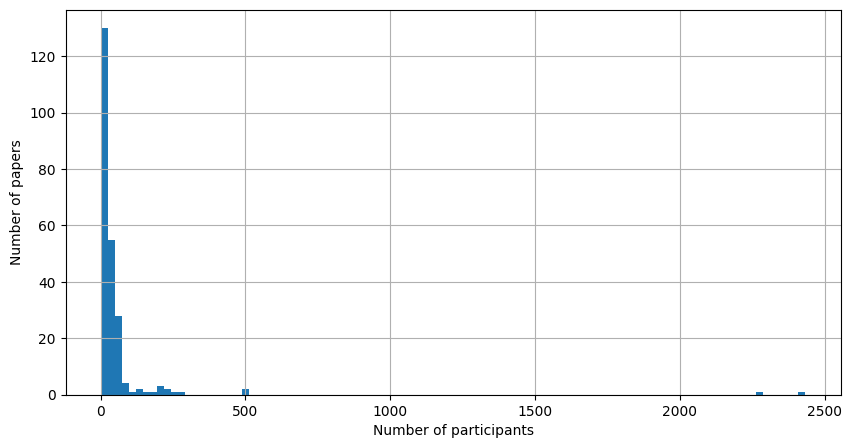

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
df["n_ptp_int"].hist(bins=100)
ax.set_ylabel("Number of papers")
ax.set_xlabel("Number of participants")

## Sample sizes over time

<AxesSubplot: xlabel='publication_year', ylabel='n_ptp_int'>

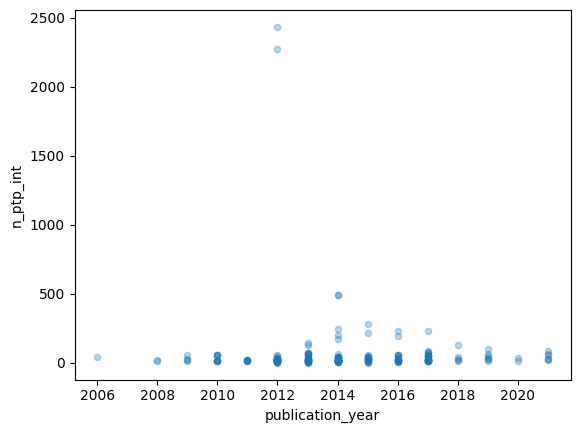

In [6]:
fig, ax = plt.subplots()
df.plot.scatter(x="publication_year", y="n_ptp_int", ax=ax, alpha=0.3)

<AxesSubplot: xlabel='publication_year', ylabel='n_ptp_int'>

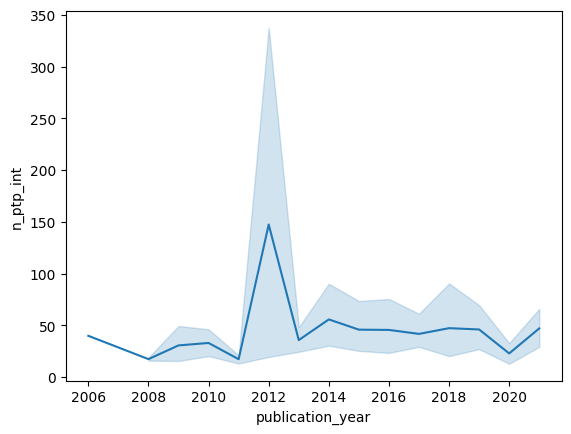

In [7]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="publication_year", y="n_ptp_int", ax=ax)